<a href="https://colab.research.google.com/github/Ricardo0621/DLCDataPreprocessing/blob/master/DLCDataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading and preprocessing pose data

This notebook downloads data from the [DeepLabCut Github repo]( https://github.com/DeepLabCut/DeepLabCut/) and converts it into numpy arrays for analysis.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from tqdm.auto import trange
import urllib.request
from copy import deepcopy
from google.colab import drive
import pickle

In [ ]:
#@title Helper functions
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import base64

# Set some plotting defaults
sns.set_context("talk")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])



_VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def _anim_to_html(anim, fps=20):
    # todo: todocument
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=fps, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video)

    return _VIDEO_TAG.format(anim._encoded_video.decode('ascii'))

def _display_animation(anim, fps=30, start=0, stop=None):
    plt.close(anim._fig)
    return HTML(_anim_to_html(anim, fps=fps))

def play(movie, fps=30, speedup=1, fig_height=6,
         show_time=False):
    # First set up the figure, the axis, and the plot element we want to animate
    T, Py, Px = movie.shape[:3]
    fig, ax = plt.subplots(1, 1, figsize=(fig_height * Px/Py, fig_height))
    im = plt.imshow(movie[0], interpolation='None', cmap=plt.cm.gray)

    if show_time:
        tx = plt.text(0.75, 0.05, 't={:.3f}s'.format(0), 
                    color='white',
                    fontdict=dict(size=12),
                    horizontalalignment='left',
                    verticalalignment='center', 
                    transform=ax.transAxes)
    plt.axis('off')

    def animate(i):
        im.set_data(movie[i * speedup])
        if show_time: 
            tx.set_text("t={:.3f}s".format(i * speedup / fps))
        return im, 

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, 
                                   frames=T // speedup, 
                                   interval=1, 
                                   blit=True)
    plt.close(anim._fig)

    # return an HTML video snippet
    print("Preparing animation. This may take a minute...")
    return HTML(_anim_to_html(anim, fps=30))


def load_video(filename, downsample=1):
    """Load a video into memory and convert to a numpy array."""
    vid = cv2.VideoCapture(filename)
    width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    num_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    num_channels = 3
    fps = vid.get(cv2.CAP_PROP_FPS)

    # Downsample the data to save memory
    data = np.zeros((num_frames, height // downsample, width // downsample, 3), dtype=np.uint8)
    for t in trange(num_frames):
        # Read the next frame
        ret, frame = vid.read()
        # Downsample the image to save memory
        frame = cv2.resize(frame, (width // downsample, height // downsample))
        # The frame is loaded in BGR format instead of RGG. Flip it.
        data[t] = np.flip(frame, 2)
    return data


# Load the keypoints
def download_training_images(basepath, csv_file):
    train_keypoints = pd.read_csv(csv_file, header=[1,2], index_col=0)

    # Download the corresponding images.  
    # Note that these are not exactly the same as the video frames!
    # In fact, they are not even all the same shape. Some are zoomed and cropped.
    print("Downloading training images")
    train_images = []
    for i in trange(len(train_keypoints)):
        filename = train_keypoints.index[i].split('/')[-1]
        with urllib.request.urlopen(basepath + '/' + filename) as f:
            buf = np.frombuffer(f.read(), dtype=np.uint8)
            train_images.append(cv2.imdecode(buf, cv2.IMREAD_COLOR))
    return train_images

# Prepare the data

In [ ]:
!wget -nc https://github.com/DeepLabCut/DeepLabCut/raw/master/examples/Reaching-Mackenzie-2018-08-30/videos/reachingvideo1.avi

test_images = load_video("reachingvideo1.avi")
play(test_images)

--2021-02-03 03:45:19--  https://github.com/DeepLabCut/DeepLabCut/raw/master/examples/Reaching-Mackenzie-2018-08-30/videos/reachingvideo1.avi
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DeepLabCut/DeepLabCut/master/examples/Reaching-Mackenzie-2018-08-30/videos/reachingvideo1.avi [following]
--2021-02-03 03:45:19--  https://raw.githubusercontent.com/DeepLabCut/DeepLabCut/master/examples/Reaching-Mackenzie-2018-08-30/videos/reachingvideo1.avi
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13485680 (13M) [application/octet-stream]
Saving to: ‘reachingvideo1.avi’

reachingvideo1.avi  100%[======


Preparing animation. This may take a minute...


In [ ]:
!wget -nc https://raw.githubusercontent.com/DeepLabCut/DeepLabCut/master/examples/Reaching-Mackenzie-2018-08-30/labeled-data/reachingvideo1/CollectedData_Mackenzie.csv
basepath = 'https://raw.githubusercontent.com/DeepLabCut/DeepLabCut/master/examples/Reaching-Mackenzie-2018-08-30/labeled-data/reachingvideo1/'
csv_file = "CollectedData_Mackenzie.csv"

--2021-02-03 03:45:47--  https://raw.githubusercontent.com/DeepLabCut/DeepLabCut/master/examples/Reaching-Mackenzie-2018-08-30/labeled-data/reachingvideo1/CollectedData_Mackenzie.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11031 (11K) [text/plain]
Saving to: ‘CollectedData_Mackenzie.csv’

CollectedData_Macke 100%[===================>]  10.77K  --.-KB/s    in 0.001s  

2021-02-03 03:45:47 (20.4 MB/s) - ‘CollectedData_Mackenzie.csv’ saved [11031/11031]



## Load the CSV file with keypoint locations

In [ ]:
train_keypoints_csv = pd.read_csv(csv_file, header=[1,2], index_col=0)
train_keypoints_csv.head()

bodyparts                                     Hand  ...   Joystick2
coords                                           x  ...           y
labeled-data/reachingvideo1/img005.png  185.251735  ...  623.143961
labeled-data/reachingvideo1/img020.png  191.642577  ...  623.143961
labeled-data/reachingvideo1/img023.png  189.086240  ...  630.812972
labeled-data/reachingvideo1/img028.png  208.258768  ...  615.474950
labeled-data/reachingvideo1/img031.png  284.948876  ...  625.700298

[5 rows x 10 columns]

## Download the training images
The first column specifies the filename of the training image (as a relative path in the Github repo). The next cell downloads those images and loads them as a list of Numpy arrays. Each entry in the array is a `(height, width, 3)` array of type `uint8`. We return them as a list because the train images are not all the same shape. Some are cropped and zoomed.

In [ ]:
train_images = download_training_images(basepath, csv_file)

## Plot training images and keypoints


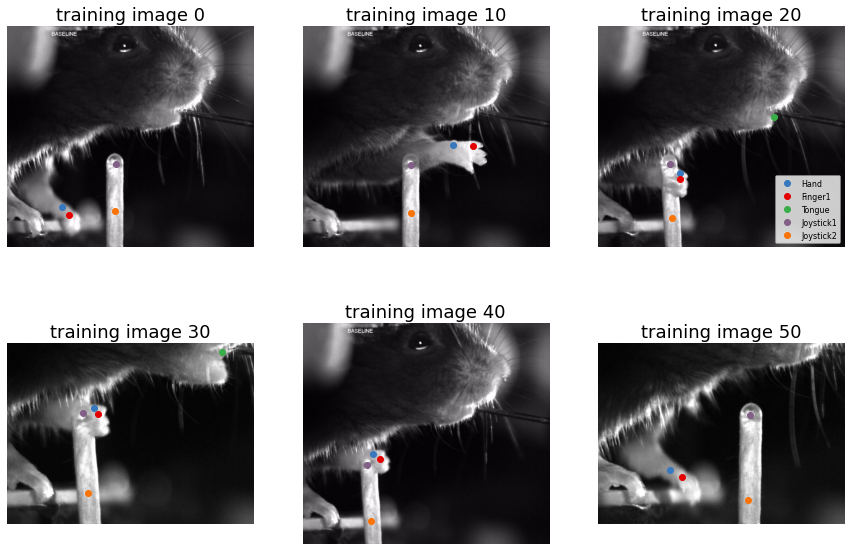

In [ ]:
# Plot some of the training data
def plot_train_img_and_keypoints(train_keypoints_csv, train_images, indices, 
                                 panel_size=5, num_cols=3):
    """Plot an image and corresponding keypoints from training dataset."""
    num_panels = len(indices)
    num_rows = int(np.ceil(num_panels / num_cols))
    fig, axs = plt.subplots(num_rows, num_cols, 
                            figsize=(panel_size * num_cols, 
                                     panel_size * num_rows))
    
    keypoint_names = [col[0] for col in train_keypoints_csv.columns[::2]]

    for k in range(num_panels):
        row, col = k // num_cols, k % num_cols
        index = indices[k]
        axs[row, col].imshow(train_images[index])
        for name, color in zip(keypoint_names, palette):
            axs[row, col].plot(train_keypoints_csv[(name, 'x')][index],
                               train_keypoints_csv[(name, 'y')][index], 
                               marker='o', markersize=6, linestyle='none',
                               color=color, label=name)
        axs[row, col].axis('off')
        axs[row, col].set_title("training image {}".format(index))
        if k == num_cols - 1:
            axs[row, col].legend(loc="lower right", fontsize=8)

    for k in range(num_panels, num_rows * num_cols):
        row, col = k // num_cols, k % num_cols
        axs[row, col].set_visible(False)


plot_train_img_and_keypoints(train_keypoints_csv, train_images, 
                             indices=[0, 10, 20, 30, 40, 50])

In [ ]:
# Initialize targets (binary matrices for each image and keypoint)
keypoint_names = [col[0] for col in train_keypoints_csv.columns[::2]]
num_keypoints = len(keypoint_names)
train_coords = train_keypoints_csv.to_numpy().reshape(-1, num_keypoints, 2)
train_targets = []
for n, (image, kp) in enumerate(zip(train_images, train_coords)):
    height, width, _ = image.shape
    target = np.zeros((num_keypoints, height, width), dtype=np.bool)                
    for k in range(num_keypoints):
        if np.all(np.isfinite(kp[k])):
            target[k, int(kp[k, 1]), int(kp[k, 0])] = 1
    train_targets.append(target)

## Split the training data into train and validation

In [ ]:
from sklearn.model_selection import train_test_split
split = train_test_split(train_images, train_coords, train_targets, train_size=0.8)
train_images, val_images, train_coords, val_coords, train_targets, val_targets = split

## Pickle the training and test data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/lab4_train_data.pkl', 'wb') as f:
    pickle.dump((train_images, train_coords, train_targets), f)

In [ ]:
with open('/content/drive/My Drive/lab4_val_data.pkl', 'wb') as f:
    pickle.dump((val_images, val_coords, val_targets), f)

In [ ]:
with open('/content/drive/My Drive/lab4_test_data.pkl', 'wb') as f:
    pickle.dump(test_images, f)